<a href="https://colab.research.google.com/github/dayeon24/24-1_ML-HW/blob/main/hw02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import missingno as msno

# Kaggle에서 제공하는 위조지폐 데이터셋 로드
url = "https://raw.githubusercontent.com/dayeon24/24-1_ML-HW/main/fake_bills.csv"
df = pd.read_csv(url, sep=';')

# 데이터 확인
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# 데이터 로드 및 분석

In [ ]:
df.shape #(1500, 7) : 7개의 feature, 15000개의 sample

(1500, 7)

In [ ]:
df.isna().sum() # margin_low에 37개 결측치가 있음을 확인

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [ ]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [ ]:
df["is_genuine"].value_counts() # True : False = 2 : 1

is_genuine
True     1000
False     500
Name: count, dtype: int64

# 데이터 정제

### STEP 1. 결측치 확인 및 처리

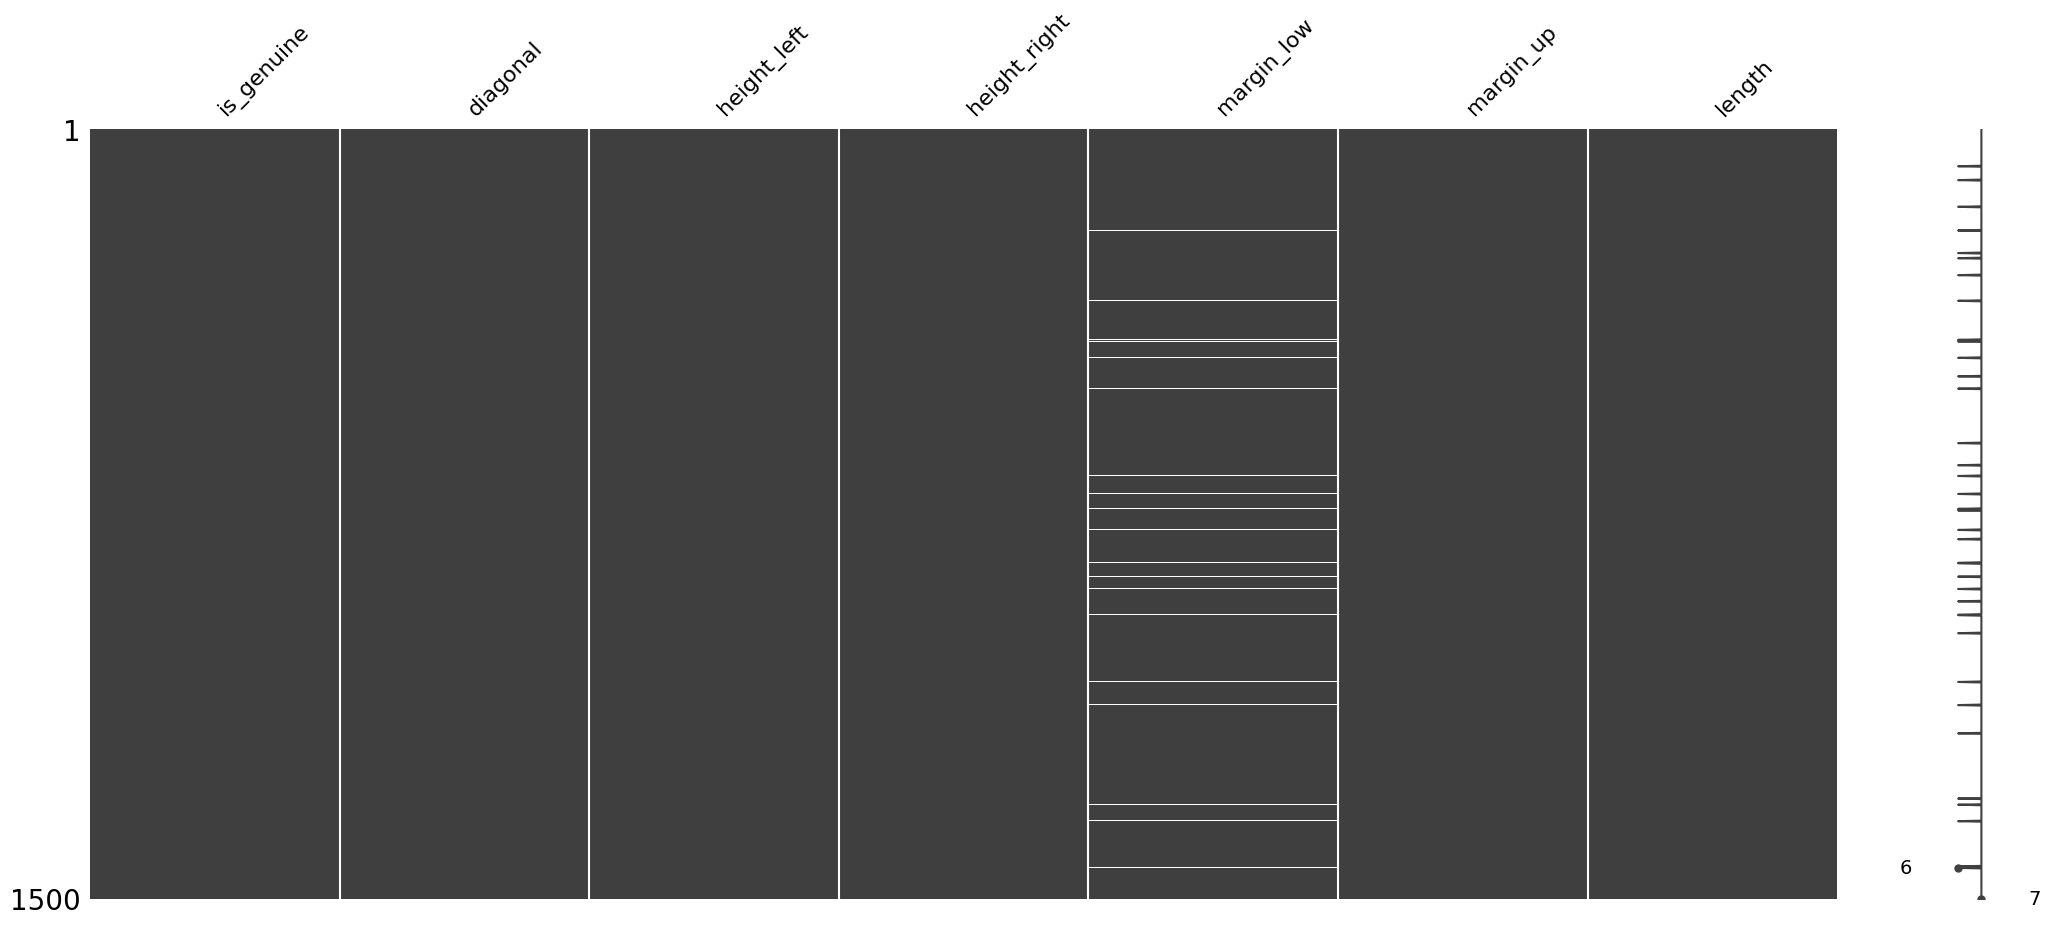

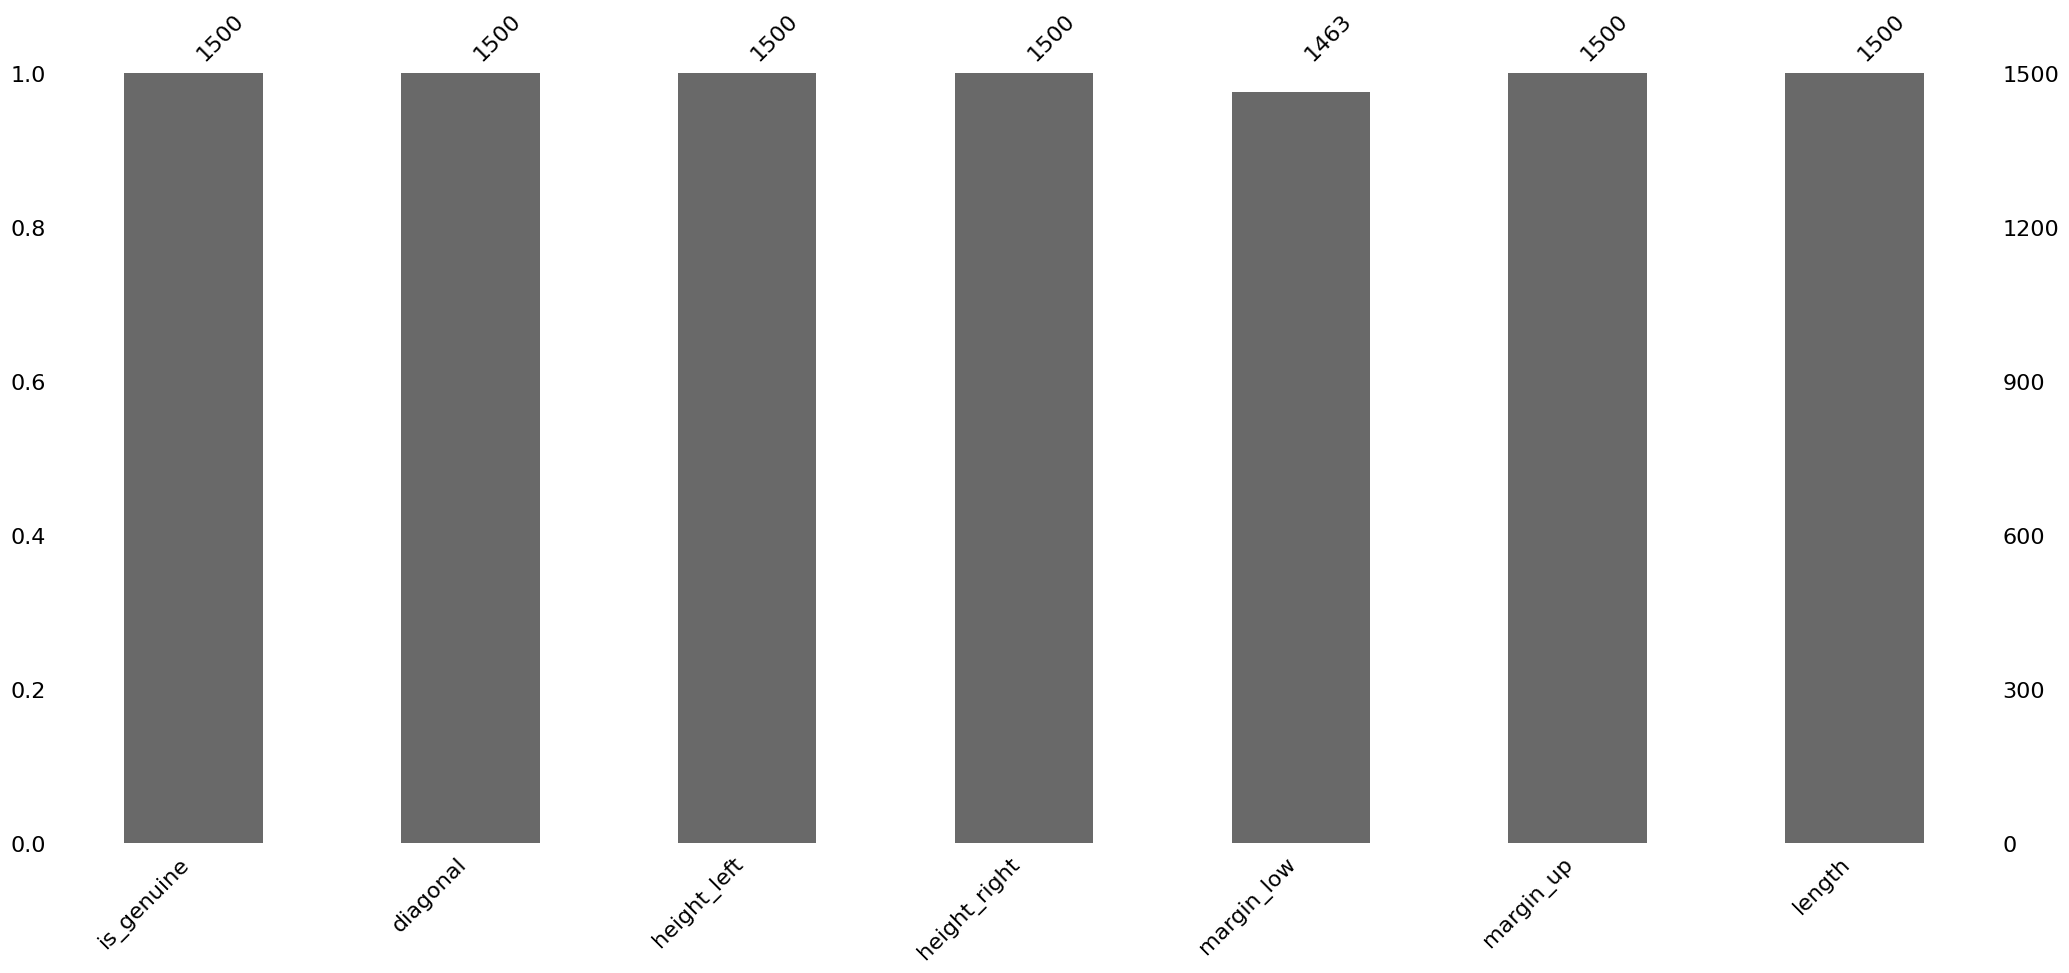

In [ ]:
# 결측치 시각화
msno.matrix(df)
plt.show()

msno.bar(df)
plt.show()

# margin_low의 결측치를 kNN을 사용하여 채우기
# fast_knn은 float 동작하지 않아 KNeighborsRegressor 이용
def fill_missing_knn(df, base, target): # base, target = x, y
    df_filled = df.copy()
    df_notna_samples = df_filled[df_filled[target].notna()]  # 모든 속성에 대해 결측값이 없는 행들을 선택
    df_isna_samples = df_filled[df_filled[target].isna()]  # target 열에 대해 결측값이 있는 행들을 선택

    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(df_notna_samples[base], df_notna_samples[target])

    df_isna_samples[target] = knn.predict(df_isna_samples[base]) # test x = df_isna_samples[base]
    df_filled.loc[df_isna_samples.index, target] = df_isna_samples[target] # 해당 index 에 target 값을 넣어, 전체 df에서 결측값 채우기

    return df_filled

base_features = [col for col in df.columns if col != 'margin_low' and col != 'is_genuine']
filled_df = fill_missing_knn(df, base_features, 'margin_low')

In [ ]:
# imputation 결과 확인
# 전체적인 통계값이 변하지 않은 것으로 보아 적절히 na 값이 채워졌음을 확인 할 수 있다.

df['margin_low'].describe(), filled_df['margin_low'].describe()

<ipython-input-6-a6517e0f7cf9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_isna_samples[target] = knn.predict(df_isna_samples[base]) # test x = df_isna_samples[base]


(count    1463.000000
 mean        4.485967
 std         0.663813
 min         2.980000
 25%         4.015000
 50%         4.310000
 75%         4.870000
 max         6.900000
 Name: margin_low, dtype: float64,
 count    1500.000000
 mean        4.485377
 std         0.660013
 min         2.980000
 25%         4.020000
 50%         4.310000
 75%         4.870000
 max         6.900000
 Name: margin_low, dtype: float64)

#### 이상치 탐지 및 처리
* 결측지를 처리한 데이터에 대해 이상치를 탐지하는 단계이다.
데이터나 목적에 따라 제거할수도, 대체값을 사용하거나 유지할 수 있다.

* 이 단계에서는 각 속성에 대한 이상치를 박스플롯을 그려 분포를 확인만 했다.

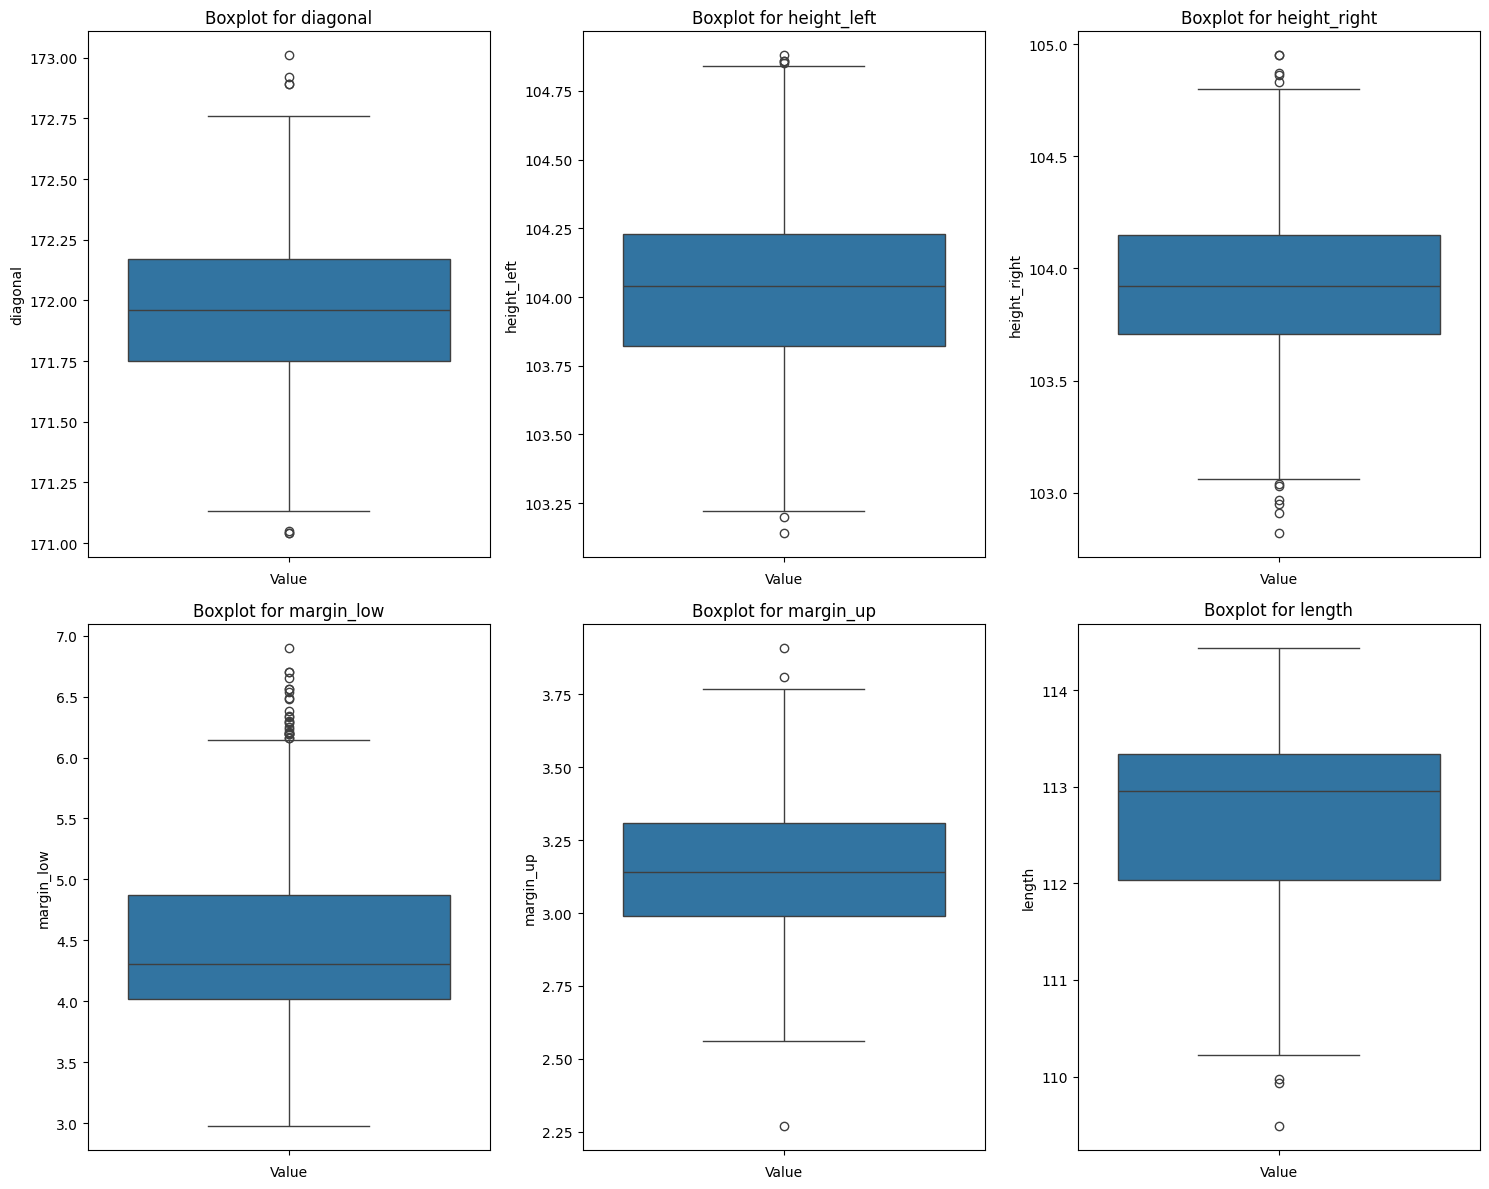

In [ ]:
# 각 속성에 대한 박스플롯 그리기
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6 * 2))
for i, column in enumerate(filled_df.columns[1:]):
    row = i // 3
    col = i % 3
    sns.boxplot(y=filled_df[column], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot for {column}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel(column)

plt.tight_layout()
plt.show()

### STEP 2. 데이터 분할

In [ ]:
# 정답(target)을 라벨 인코딩 : True = 1, False=0
filled_df['is_genuine'] = filled_df['is_genuine'].astype(int)
X = filled_df.drop('is_genuine', axis=1)
y = filled_df['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### STEP 3. 데이터 정규화

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### STEP 4. EDA

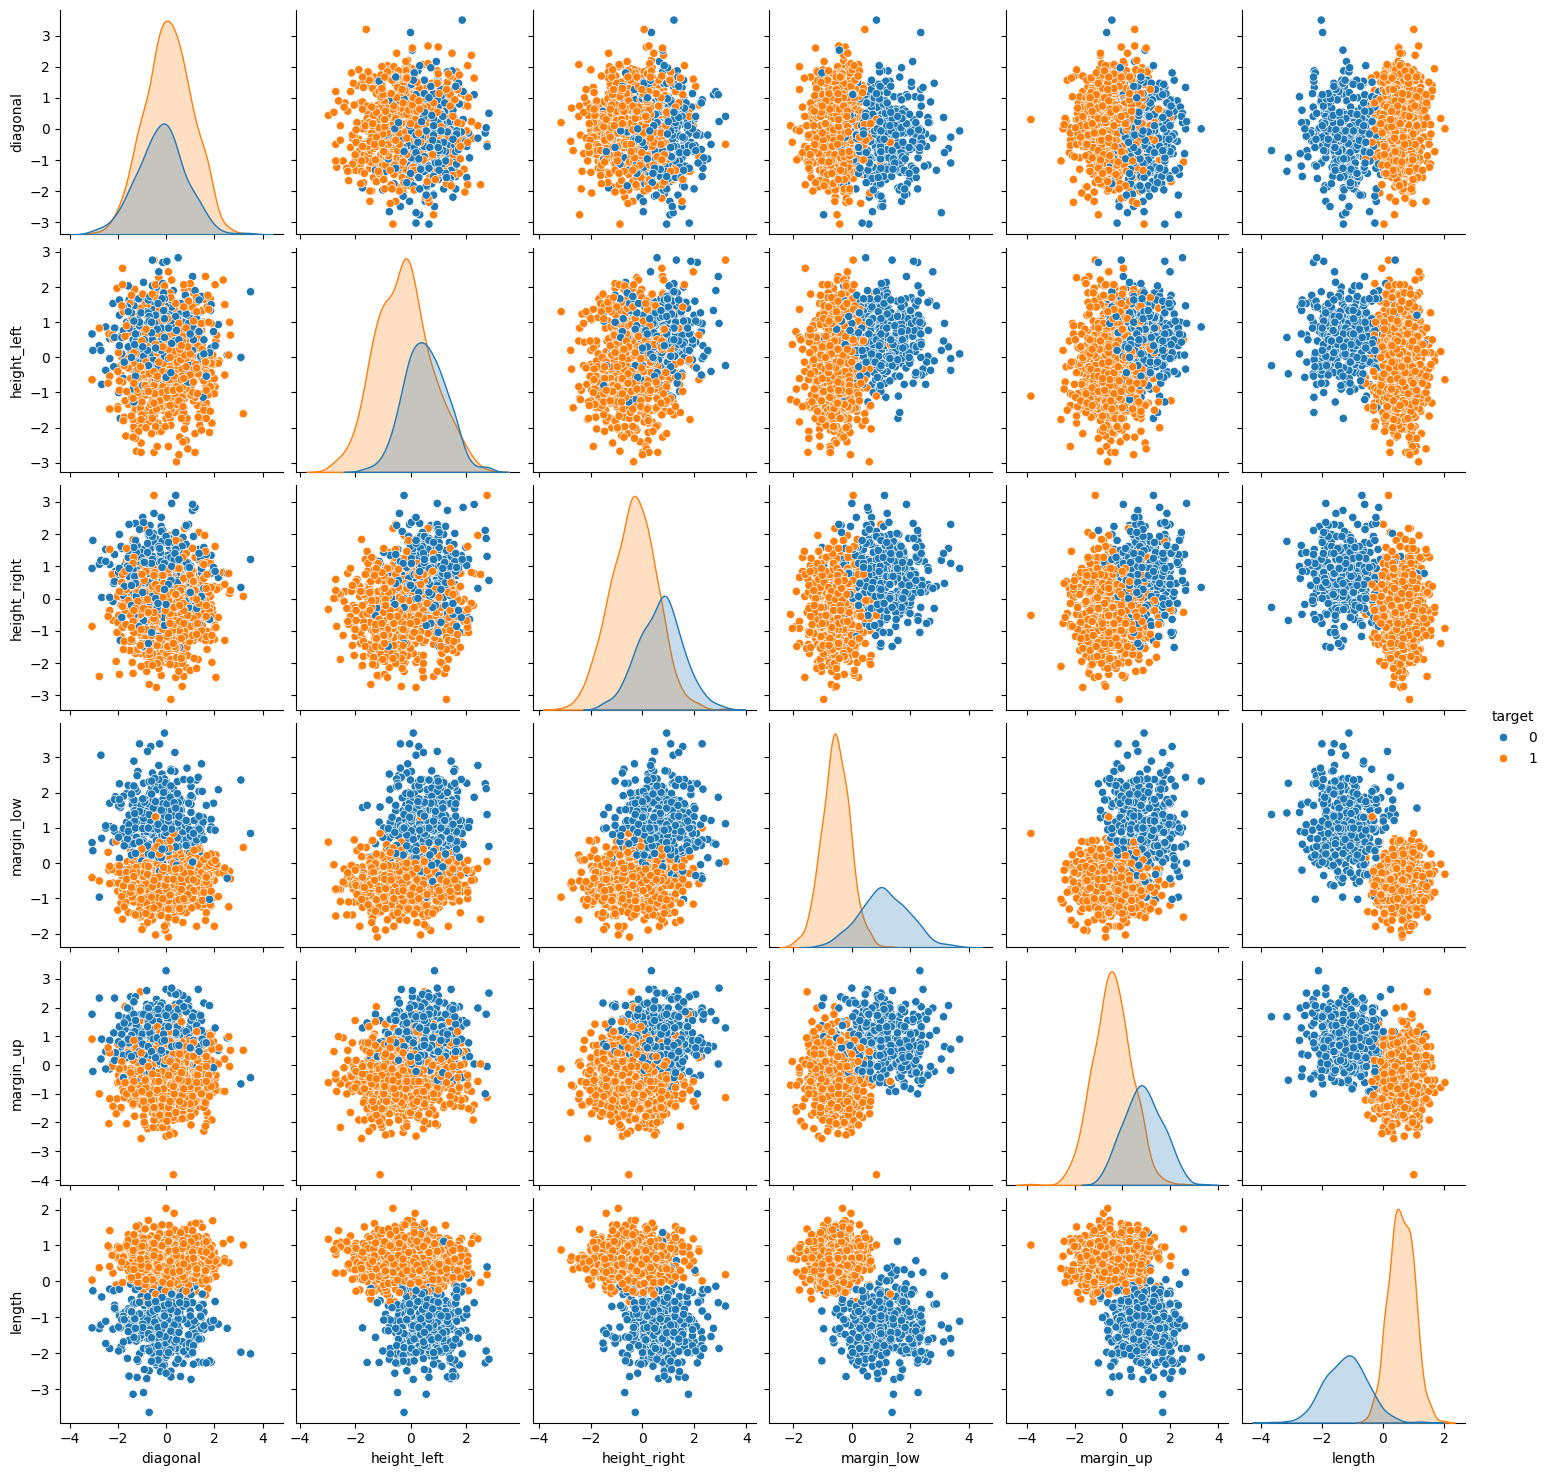

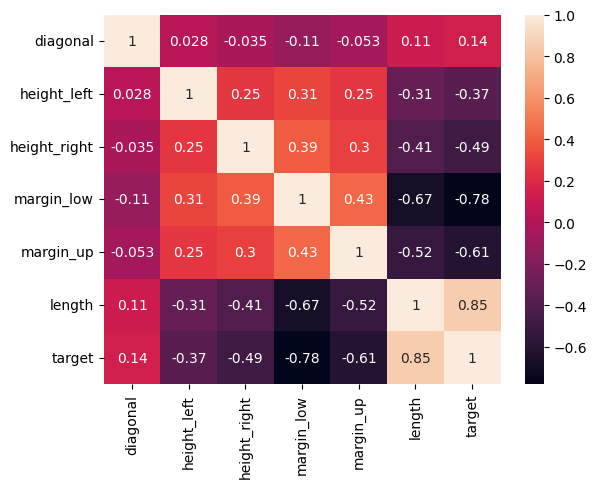

In [ ]:
train_data = pd.DataFrame(X_train_scaled, columns=X_train.columns)
train_data['target'] = y_train

train_data['target'] = y_train.reset_index(drop=True)
plt.show()

# pairplot
sns.pairplot(train_data, hue='target')
plt.show()

# correlation matrix
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

### STEP 5. 모델 학습 및 평가

In [ ]:
def perform_grid_search_knn(X_train, X_test, y_train, y_test):
  # Cross Validation을 이용
  # k에 대해 1~30까지 Grid Search
  param_grid = {'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance']}
  knn = KNeighborsClassifier()
  grid_search = GridSearchCV(knn, param_grid, cv=10)
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  best_score = grid_search.best_score_

  best_knn = grid_search.best_estimator_
  y_het = best_knn.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_het)

  # 결과 출력
  print("Best parameters:", best_params)
  print("Best cross-validation score: {:.2f}".format(best_score))
  print("Test set accuracy: {:.2f}".format(test_accuracy))

In [ ]:
perform_grid_search_knn(X_train_scaled, X_test_scaled, y_train,y_test)

Best parameters: {'n_neighbors': 6, 'weights': 'uniform'}
Best cross-validation score: 0.99
Test set accuracy: 0.99


# 추가 학습
간단한 EDA를 통해 다음을 알 수 있었다.
1. length가 target을 구분하는 key feature 이다.
2. 중요한 피처인 length와 높은 상관관계있는 feature는 margin_low, margin_up이다.

따라서 length', 'margin_low', 'margin_up' feature 만으로도 모델의 성능이 좋은지 확인해보고자했다.

결과적으로, 3개의 feature 만으로도 잘 학습하는 것을 확인할 수 있었다.

이는 accarcy 와 각각의 최적의 n_neighbors 수를 비교함으로써 확인할 수 있었다.

(neighbors, test set accuracy)
1. 6개 features : 6, 0.99
2. 3개 main features : 4, 0.99
3. 1개 feature(length) : 7, 0.94
4. 1개 feature(margin_low) : 23, 0.94

하지만 데이터에 대해 과적합한 결과일 수 있기 때문에,
accuracy가 높다고 일반화 성능이 좋다고는 말할 수 없다.

또한 feature간의 상관관계가 높은 데이터를 사용할 때에도 과적합할 가성이 높다. 이는 PCA 단계를 추가함으로써 완화시킬 수 있다.

In [ ]:
mainX = filled_df[['length', 'margin_low', 'margin_up']]  # 중요한 피처들만 선택
mainy = filled_df['is_genuine']

mainX_train, mainX_test, mainy_train, mainy_test = train_test_split(mainX, mainy, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
mainX_train_scaled = scaler.fit_transform(mainX_train)
mainX_test_scaled = scaler.transform(mainX_test)

perform_grid_search_knn(mainX_train_scaled, mainX_test_scaled, mainy_train,mainy_test)

Best parameters: {'n_neighbors': 4, 'weights': 'distance'}
Best cross-validation score: 0.99
Test set accuracy: 0.99


In [ ]:
mainX = filled_df[['length']]  # 중요한 피처들만 선택
mainy = filled_df['is_genuine']

mainX_train, mainX_test, mainy_train, mainy_test = train_test_split(mainX, mainy, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
mainX_train_scaled = scaler.fit_transform(mainX_train)
mainX_test_scaled = scaler.transform(mainX_test)

perform_grid_search_knn(mainX_train_scaled, mainX_test_scaled, mainy_train,mainy_test)

Best parameters: {'n_neighbors': 7, 'weights': 'uniform'}
Best cross-validation score: 0.96
Test set accuracy: 0.94


In [ ]:
mainX = filled_df[['margin_low']]  # 중요한 피처들만 선택
mainy = filled_df['is_genuine']

mainX_train, mainX_test, mainy_train, mainy_test = train_test_split(mainX, mainy, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
mainX_train_scaled = scaler.fit_transform(mainX_train)
mainX_test_scaled = scaler.transform(mainX_test)

perform_grid_search_knn(mainX_train_scaled, mainX_test_scaled, mainy_train,mainy_test)

Best parameters: {'n_neighbors': 23, 'weights': 'uniform'}
Best cross-validation score: 0.92
Test set accuracy: 0.94
